# Convolution Operation

This additional part of the tutorial contains an example for understanding the 2D convolution operation, that is the basic function of the **Convolutional Neural Network (CNN)** layers

<img src="http://deeplearning.net/software/theano_versions/dev/_images/numerical_padding_strides.gif" width="320" border="1"/>

(*Objective: Understand convolution operation, its place in neural networks and origins of the idea in visual neuroscience. Time: 10 mins*)

## Loading images from URLs

We load an image from URL using the `requests` standard Python package and the Python Imaging Library - `PIL`.

In [0]:
import tensorflow as tf
import numpy as np

import requests
from PIL import Image
from io import BytesIO

IMAGE_URL = "http://www.visitgreece.gr/deployedFiles/StaticFiles/Photos/Generic%20Contents/Poleis/white_tower_2_560.jpg"

oResponse = requests.get(IMAGE_URL)
nImage = Image.open(BytesIO(oResponse.content))

Using matplotlib we can display the loaded image

(373, 560, 3)


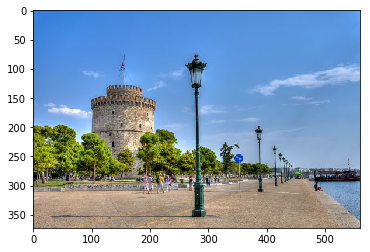

In [0]:
import matplotlib.pyplot as plt

plt.imshow(nImage)

# We convert the Image object into a numpy 3D tensor.
nImageIn = np.array(nImage)

print(nImageIn.shape)

## Convolution with handcrafted kernels
The following declares a 2D convolution operation on an RGB image. 

### Imlementation Notes
*  We create several 3x3 filter arrays `nZeroChannel`, `nGaussianFilter`, `nSobelFilter`, etc.
*  The convolutional kernel is a 4D tensor declared as tensor `tW` and its initial session values are given in numpy array `nW`.
*  The padding="VALID" parameter in tf.nn.conv2d means that the image will not be padded. Using "SAME" will do automatic zero padding to preserve the same spatial dimensions.
*  The code applies a sobel filter on each one of the input RGB channels resulting in 3 output channels.

In [0]:
# Input is a 4D tensor with count of input samples to 1, image spatial dimensions, and 3 channels
nInputShape = [1] + list(nImageIn.shape[:2]) + [3]
print("Input Shape:", nInputShape)
tX = tf.placeholder(tf.uint8, shape=nInputShape)
tIn = tf.cast(tX, tf.float32)/255.0


nZeroChannel      = np.zeros((3,3,1,1), np.float32)

nGaussianFilter   = np.asarray([[1.0/16.0 , 1.0/8.0 , 1.0/16.0], 
                                [1.0/8.0  , 1.0/4.0 , 1.0/8.0], 
                                [1.0/16.0 , 1.0/8.0 , 1.0/16.0]], np.float32).reshape((3,3,1,1))
                                
nDummyFilter      = np.asarray([[0.0, 0.0, 0.0],
                                [0.0, 1.0, 0.0],
                                [0.0, 0.0, 0.0]], np.float32).reshape((3,3,1,1))
                                
nAverageFilter    = np.ones((3,3,1,1), np.float32)*(1.0/9.0)
nSimpleEdgeFilter = np.asarray([[-1.0, 1.0, 0.0],
                                [-1.0, 1.0, 0.0],
                                [-1.0, 1.0, 0.0]], np.float32).reshape((3,3,1,1))
                                
nSobelFilter      = np.asarray([[-1.0, 0.0, 1.0], 
                                [-2.0, 0.0, 2.0], 
                                [-1.0, 0.0, 1.0]], np.float32).reshape((3,3,1,1))

# Here you select the filter to be applied to each input-to-output channel 2D convolution
nF_Out1_InR = nSobelFilter
nF_Out1_InG = nZeroChannel
nF_Out1_InB = nZeroChannel

nF_Out2_InR = nZeroChannel
nF_Out2_InG = nSobelFilter
nF_Out2_InB = nZeroChannel

nF_Out3_InR = nZeroChannel
nF_Out3_InG = nZeroChannel
nF_Out3_InB = nSobelFilter

# Compose 3D tensors for each output channel, out of 2D filters
nW_Out1 = np.dstack((nF_Out1_InR,nF_Out1_InG, nF_Out1_InB))
nW_Out2 = np.dstack((nF_Out2_InR,nF_Out2_InG, nF_Out2_InB))
nW_Out3 = np.dstack((nF_Out3_InR,nF_Out3_InG, nF_Out3_InB))

# Compose the 4D tensor that is the convolutional kernel
nW = np.concatenate((nW_Out1, nW_Out2, nW_Out3), axis=3)

print("Convolutional Kernel Shape:", nW.shape)

# Convolution operation that its output will be restrained to [0, 1]
tW = tf.Variable(nW, tf.float32)
tU = tf.nn.conv2d(tIn, tW, strides=[1,2,2,1], padding="VALID")
tA = tf.clip_by_value(tU, 0.0, 1.0)

Input Shape: [1, 373, 560, 3]
Convolutional Kernel Shape: (3, 3, 3, 3)


4D Convolutional Kernel Visualization


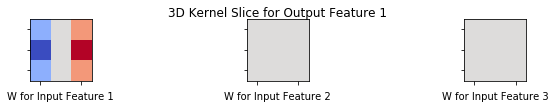

................................................................................


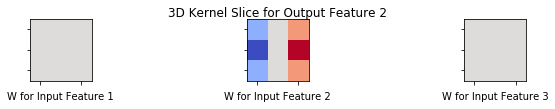

................................................................................


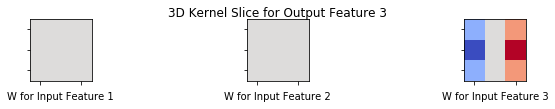

................................................................................


In [32]:
import matplotlib.pyplot as plt

# --------------------------------------------------------------------------------------------------------      
def VisualizeFilters(p_oPatches, p_sTitle):
  oFigure, oAxis = plt.subplots(1, len(p_oPatches),figsize=(10, 1.5), sharex=True, sharey=True)
  oFigure.suptitle(p_sTitle)
  for nIndex, nPatch in enumerate(p_oPatches):
    oAx = oAxis[nIndex]
    oAx.set_yticklabels([])
    oAx.set_xticklabels([])
    oAx.set_xlabel("W for Input Feature " + str(nIndex + 1))
    oAx.imshow(nPatch, vmin=-2, vmax=2, cmap="coolwarm")
  plt.tight_layout()  
  plt.show()
# --------------------------------------------------------------------------------------------------------   
print("="*80)
print("4D Convolutional Kernel Visualization")
print("="*80)
for nOutputFeatureIndex in range(nW.shape[3]):
  oFilters = []
  for nInputFeatureIndex in range(nW.shape[2]):
    oFilters.append(nW[:,:, nInputFeatureIndex, nOutputFeatureIndex])
  
  VisualizeFilters(oFilters, "3D Kernel Slice for Output Feature %d" % (nOutputFeatureIndex + 1))
  print("."*80)
print("="*80)  


### tf.nn.conv2d
*   The padding="VALID" parameter in tf.nn.conv2d means that the image will not be padded. Using "SAME" will do automatic zero padding to preserve the same spatial dimensions.
*   The strides have 4 values as it expects a 4D tensor `tIn`. The setting [2,1,1,1] mean a stride every two images and [1,1,1,2] as stride on RGB channels of image. Usually the same stride is used for horizontal and vertical dimensions.
*  We add a dimension to `nImageIn` using `np.newaxis` make the input image 4D tensor.
*  We can use a notation to describe the above convolution operation: 

  `[KernelWidth x KernelHeight/Stride | InputDimensionality -> OutputDimensionality]`
  
  thus we implement a `[3 x 3/2 | 3 -> 3]` convolution.

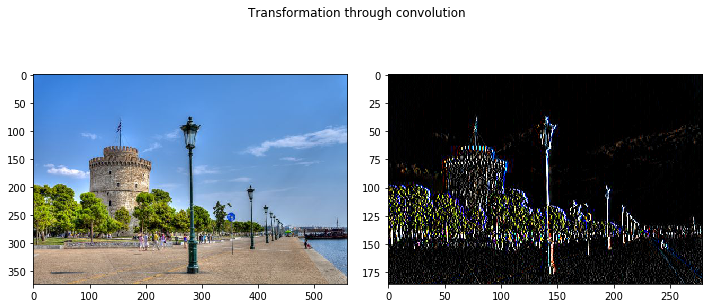

Input Image:(373, 560, 3) -> Output Image:(1, 186, 279, 3)


In [12]:
with tf.Session() as oSession:
    oSession.run(tf.initializers.global_variables())
    
    nRepresentationsOut = oSession.run(tA, feed_dict={tX:nImageIn[np.newaxis, ...]})
    nImageOut = (nRepresentationsOut[0,...]*255.0).astype(np.uint8)
    
    
    oFigure, oAxis = plt.subplots(1,2, figsize=(10, 5))
    oFigure.suptitle("Transformation through convolution")
    oAxis[0].imshow(nImageIn)
    if nImageOut.shape[2] == 3:
        oAxis[1].imshow(nImageOut)
    else:
        oAxis[1].imshow(nImageOut[:,:,0], cmap="gray")
    plt.tight_layout()  
    plt.show()
    
    print("Input Image:%s -> Output Image:%s" % (nImageIn.shape, nRepresentationsOut.shape))

## Theory: Convolutional layer in neural networks.

### Feature transformation 
The 2D convolution operation on the pixels of an RGB color image, could be considered as a transformation of `d_in=3` input features to `d_out` output features. 

### Sliding window
There are `d_in * d_out` different filters of `l x l` dimensions that are applied to patches of the image, with a window that 
slides over the input with a given stride. 

### Neurons
We can think of `n = 187*280 = 52360` neurons in our example each one connected to a `l^2` local image patch, which is their [receptive field](http://www.scholarpedia.org/article/Receptive_field). The receptive fields overlap by one pixel. These neurons share the same synaptic weights stored in `tW` in our example and transform `l^2` input stimuli of `d_in` dimensionality to `n` activations of `d_out` dimensionality.


### Downsampling
Any stride `s>1` would result in spatial downsampling of the image. In our example the image size 373x560 becomes 187x280.

### Learned filters
Through a learning process the filters in each convolutional kernel are learned from data, thus the kernels hold the model parameters (or weights). There could be an increase in the dimensionality of features as the spatial dimensions are decreasing.

## Custom implementation of 2D convolution
Bellow is a simplified implementation of a 2D convolution operation that works with 3D tensor input and 4D kernels.

Zoomed Area


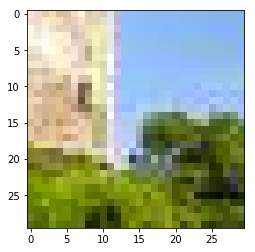

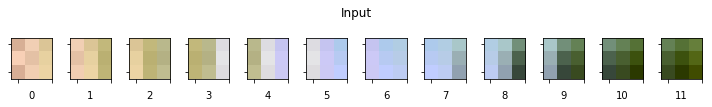

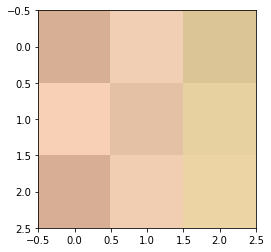

Patch #0
Input R
---------------------------------------------------------------------------
|          215.0 |          248.0 |          216.0 |
|          241.0 |          228.0 |          241.0 |
|          219.0 |          231.0 |          236.0 |
---------------------------------------------------------------------------
Input G
---------------------------------------------------------------------------
|          175.0 |          208.0 |          174.0 |
|          207.0 |          193.0 |          206.0 |
|          197.0 |          209.0 |          212.0 |
---------------------------------------------------------------------------
Input B
---------------------------------------------------------------------------
|          149.0 |          182.0 |          149.0 |
|          180.0 |          165.0 |          178.0 |
|          150.0 |          160.0 |          164.0 |
---------------------------------------------------------------------------
Tensorflow Conv2D Output=[-10.  62

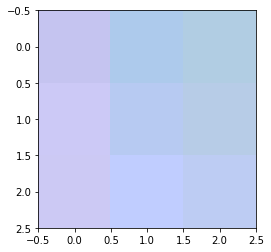

Patch #6
Input R
---------------------------------------------------------------------------
|          197.0 |          204.0 |          204.0 |
|          173.0 |          183.0 |          192.0 |
|          177.0 |          183.0 |          189.0 |
---------------------------------------------------------------------------
Input G
---------------------------------------------------------------------------
|          196.0 |          201.0 |          201.0 |
|          202.0 |          202.0 |          205.0 |
|          205.0 |          204.0 |          204.0 |
---------------------------------------------------------------------------
Input B
---------------------------------------------------------------------------
|          240.0 |          246.0 |          244.0 |
|          236.0 |          242.0 |          255.0 |
|          227.0 |          231.0 |          243.0 |
---------------------------------------------------------------------------
Tensorflow Conv2D Output=[-77.  18

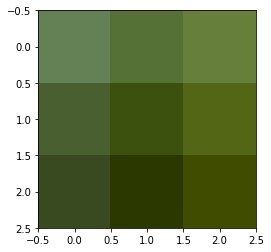

Patch #11
Input R
---------------------------------------------------------------------------
|          100.0 |           73.0 |           57.0 |
|           85.0 |           60.0 |           43.0 |
|          102.0 |           83.0 |           64.0 |
---------------------------------------------------------------------------
Input G
---------------------------------------------------------------------------
|          129.0 |           95.0 |           74.0 |
|          113.0 |           81.0 |           57.0 |
|          127.0 |          102.0 |           76.0 |
---------------------------------------------------------------------------
Input B
---------------------------------------------------------------------------
|           85.0 |           48.0 |           32.0 |
|           54.0 |           14.0 |            0.0 |
|           59.0 |           21.0 |            0.0 |
---------------------------------------------------------------------------
Tensorflow Conv2D Output=[  29.  

In [0]:
from scipy.signal import convolve2d

# --------------------------------------------------------------------------------------------------------      
def VisualizePatches(p_oPatches, p_sTitle):
  oFigure, oAxis = plt.subplots(1, len(p_oPatches),figsize=(10, 1.5), sharex=True, sharey=True)
  oFigure.suptitle(p_sTitle)
  for nIndex, nPatch in enumerate(p_oPatches):
    oAx = oAxis[nIndex]
    oAx.set_yticklabels([])
    oAx.set_xticklabels([])
    oAx.set_xlabel(str(nIndex))
    if nPatch.shape[-1] == 3:
      oAx.imshow(nPatch)
    else:
      oAx.imshow(nPatch, cmap="gray")
  plt.tight_layout()  
  plt.show()
# --------------------------------------------------------------------------------------------------------      
def PrintPatchValues(p_nImagePatch):
  print("-"*75)  
  for nRowIndex in range(p_nImagePatch.shape[1]):
    print("| %14s | %14s | %14s |" % (p_nImagePatch[0, nRowIndex],p_nImagePatch[1, nRowIndex], p_nImagePatch[2, nRowIndex]))
  print("-"*75)  
# --------------------------------------------------------------------------------------------------------      
def Conv2DNonSliding(p_nX, p_nKernel):
  nInputFeatures  = p_nKernel.shape[-2]
  nOutputFeatures = p_nKernel.shape[-1]
  
  nOutput = np.zeros((nOutputFeatures), np.float32)
  
  for nIndex in range(nOutputFeatures):
    nKernelSlice = p_nKernel[:,:,:,nIndex]
  
    nSum = 0
    for k in range(nInputFeatures):    
      # Convolution with input matrix and filter matrix
      for i in range(p_nX.shape[0]):
        for j in range(p_nX.shape[1]):
            nSum +=  p_nX[i,k,j] * nKernelSlice[i,k,j]
            
    nOutput[nIndex] = nSum
      
  return nOutput
# --------------------------------------------------------------------------------------------------------      
                                                                                                                
                                                                                                                
START_X=201
PATCHES_COUNT=12
START_Y=205


with tf.Session() as oSession:
    oSession.run(tf.initializers.global_variables())

    # Display zoomed area
    print("Zoomed Area")
    nImageArea = nImageIn[190:220, 195:225]
    plt.imshow(nImageArea)    
    plt.show()
    
    # Display stripe of patches
    oPatchesIn  = []
    nWIndex = START_Y
    for nHIndex in range(START_X, START_X + PATCHES_COUNT):
      nImagePatchIn = nImageIn[nWIndex:nWIndex+3, nHIndex:nHIndex+3,:]
      oPatchesIn.append(nImagePatchIn)
    VisualizePatches(oPatchesIn, "Input")
    
    # Convolve each patch with kernel
    for nIndex,nImagePatchIn in enumerate(oPatchesIn):
      nX = nImagePatchIn[np.newaxis, ...].astype(np.float32)
      tU = tf.nn.conv2d(tf.constant(nX, tf.float32), tW, strides=[1,1,1,1], padding="VALID")
      nTFOutput = oSession.run(tU)
      if nIndex in [0,6,11]:
        print("="*80)
        plt.imshow(nImagePatchIn)
        plt.show()
        print("Patch #%d" % nIndex)
        print("Input R")
        PrintPatchValues(nX[0,:,:,0])
        print("Input G")
        PrintPatchValues(nX[0,:,:,1])
        print("Input B")
        PrintPatchValues(nX[0,:,:,2])
        print("Tensorflow Conv2D Output=%s" % (nTFOutput.reshape(-1)))
        
        tCustomOutput = Conv2DNonSliding(nImagePatchIn.astype(np.float32), nW)        
        print("Custom Conv2D Output    =%s" % tCustomOutput)